In [1]:
from nbodykit.lab import *
from fastpm.nbkit import FastPMCatalogSource
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

import sys
sys.path.append('../general_routines/')
from general_tools import *
from catalogue_generation import *

In [2]:
Nc = 256
Length = 1000. # Mpc  h-1
zobs = 0.3

# Setup initial conditions
cosmo = cosmology.Planck15

power = cosmology.LinearPower(cosmo, redshift=zobs)
linear = LinearMesh(power, BoxSize=Length, Nmesh=Nc, seed=21)

In [4]:
linear.save('Lmesh.bigfile')

/home/pdcg/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/nbodykit/source/mesh/linear.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mask = numpy.bitwise_and.reduce([ki == 0 for ki in k])


In [3]:
matter = FastPMCatalogSource(linear, Nsteps=10)
NL_mesh = matter.to_mesh(resampler='cic', interlaced=True, compensated=True)
# NL_mesh.save('NL_mesh')

/home/pdcg/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/nbodykit/source/mesh/linear.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mask = numpy.bitwise_and.reduce([ki == 0 for ki in k])


In [4]:
# NL_mesh = BigFileMesh('NL_mesh.bigfile', dataset='Field')

deltaICNL = convolve_NL(Length, Nc, (linear.paint(mode='real') - 1.), (NL_mesh.paint(mode='real') - 1.))
Nlinear = ArrayMesh(deltaICNL + 1., Length)

KeyboardInterrupt: 

In [6]:
NLfield = NL_field(linear, NL_mesh)
Nlinear = FieldMesh(NLfield)

/home/pdcg/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/nbodykit/source/mesh/linear.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mask = numpy.bitwise_and.reduce([ki == 0 for ki in k])


In [ ]:
r = FFTPower(linear, mode='1d')
Pklin = r.power['power'].real
k = r.power['k']

r = FFTPower(Nlinear, mode='1d')
Pknlin = r.power['power'].real

Text(0, 0.5, '$P(k) \\, [\\mathrm{h}^3 \\mathrm{Mpc}^{-3}]$')

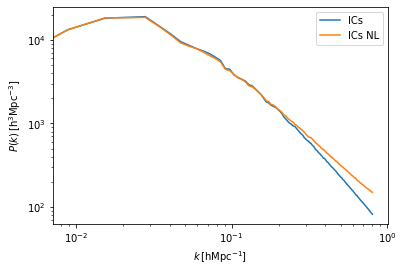

In [ ]:
plt.loglog(k, Pklin, label='ICs')
plt.loglog(k, Pknlin, label='ICs NL')
plt.legend()
plt.xlabel(r'$k \, [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{h}^3 \mathrm{Mpc}^{-3}]$')

In [ ]:
forward_displf = compute_Psi(Length, Nc, Nlinear.paint(mode='real') - 1.)
forward_displf1 = compute_Psi(Length, Nc, linear.paint(mode='real') - 1.)

/home/pdcg/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/nbodykit/source/mesh/linear.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mask = numpy.bitwise_and.reduce([ki == 0 for ki in k])


In [ ]:
matter_pos = forward_evolution(Length, Nc, forward_displf)
matter_pos1 = forward_evolution(Length, Nc, forward_displf1)

In [ ]:
ww = np.ones(len(matter_pos))
with open('matter_file.dat', 'wb') as ff:
    matter_pos.tofile(ff); ww.tofile(ff); ff.seek(0)

matter_cat = BinaryCatalog(ff.name, [('Position', ('f8', 3)), ('Mass', ('f8', 1))], size=len(matter_pos))
matter_cat.attrs['BoxSize'] = np.array([Length, Length, Length])
matter_cat.attrs['Nmesh'] = np.array([Nc, Nc, Nc])
delta_dm = matter_cat.to_mesh(resampler='cic', interlaced=True, compensated=True)

ww1 = np.ones(len(matter_pos1))
with open('matter_file1.dat', 'wb') as ff1:
    matter_pos1.tofile(ff1); ww1.tofile(ff1); ff1.seek(0)

matter_cat1 = BinaryCatalog(ff1.name, [('Position', ('f8', 3)), ('Mass', ('f8', 1))], size=len(matter_pos1))
matter_cat1.attrs['BoxSize'] = np.array([Length, Length, Length])
matter_cat1.attrs['Nmesh'] = np.array([Nc, Nc, Nc])
delta_dm1 = matter_cat1.to_mesh(resampler='cic', interlaced=True, compensated=True)

/home/pdcg/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/nbodykit/io/binary.py:74: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype = numpy.dtype(dtype)


In [ ]:
r = FFTPower(delta_dm, mode='1d')
Pkdm = r.power['power'].real - r.attrs['shotnoise']

r = FFTPower(delta_dm1, mode='1d')
Pkdm1 = r.power['power'].real - r.attrs['shotnoise']

Text(0, 0.5, '$P(k) \\, [\\mathrm{h}^3 \\mathrm{Mpc}^{-3}]$')

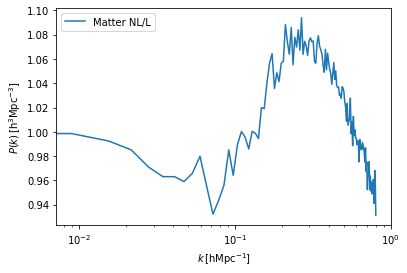

In [ ]:
# plt.loglog(k, Pklin, label='ICs L')
# plt.loglog(k, Pknlin, label='ICs NL')
plt.plot(k, Pkdm/Pkdm1, label='Matter NL/L')
# plt.loglog(k, Pkdm1, ':',label='Matter L')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$k \, [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{h}^3 \mathrm{Mpc}^{-3}]$')

In [ ]:
alpha = 1.3
delta_th = 0.
gamma = 0.02
# n0 = 3.6e-4
# gamma = n0/np.mean((delta_dm.paint(mode='real'))**alpha)

galaxy_pos = make_catalog_g((delta_dm.paint(mode='real') - 1.), alpha, gamma, delta_th, Length, Nc)
galaxy_pos1 = make_catalog_g((delta_dm1.paint(mode='real') - 1.), alpha, gamma, delta_th, Length, Nc)

In [ ]:
Ng = len(galaxy_pos)
n = Ng/Length**3
print('Total of galaxies = ', Ng)
print('Galaxy number density = ', n)
Ng = len(galaxy_pos1)
n = Ng/Length**3
print('Total of galaxies = ', Ng)
print('Galaxy number density = ', n)

Total of galaxies =  438853
Galaxy number density =  0.000438853
Total of galaxies =  430890
Galaxy number density =  0.00043089


In [ ]:
ww = np.ones(len(galaxy_pos))
with open('galaxy_file.dat', 'wb') as ff:
    galaxy_pos.tofile(ff); ww.tofile(ff); ff.seek(0)

galaxy_cat = BinaryCatalog(ff.name, [('Position', ('f8', 3)), ('Mass', ('f8', 1))], size=len(galaxy_pos))
galaxy_cat.attrs['BoxSize'] = np.array([Length, Length, Length])
galaxy_cat.attrs['Nmesh'] = np.array([Nc, Nc, Nc])
delta_g = galaxy_cat.to_mesh(resampler='cic', interlaced=True, compensated=True)

ww1 = np.ones(len(galaxy_pos1))
with open('galaxy_file1.dat', 'wb') as ff1:
    galaxy_pos1.tofile(ff1); ww.tofile(ff1); ff1.seek(0)

galaxy_cat1 = BinaryCatalog(ff1.name, [('Position', ('f8', 3)), ('Mass', ('f8', 1))], size=len(galaxy_pos1))
galaxy_cat1.attrs['BoxSize'] = np.array([Length, Length, Length])
galaxy_cat1.attrs['Nmesh'] = np.array([Nc, Nc, Nc])
delta_g1 = galaxy_cat1.to_mesh(resampler='cic', interlaced=True, compensated=True)

/home/pdcg/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/nbodykit/io/binary.py:74: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype = numpy.dtype(dtype)


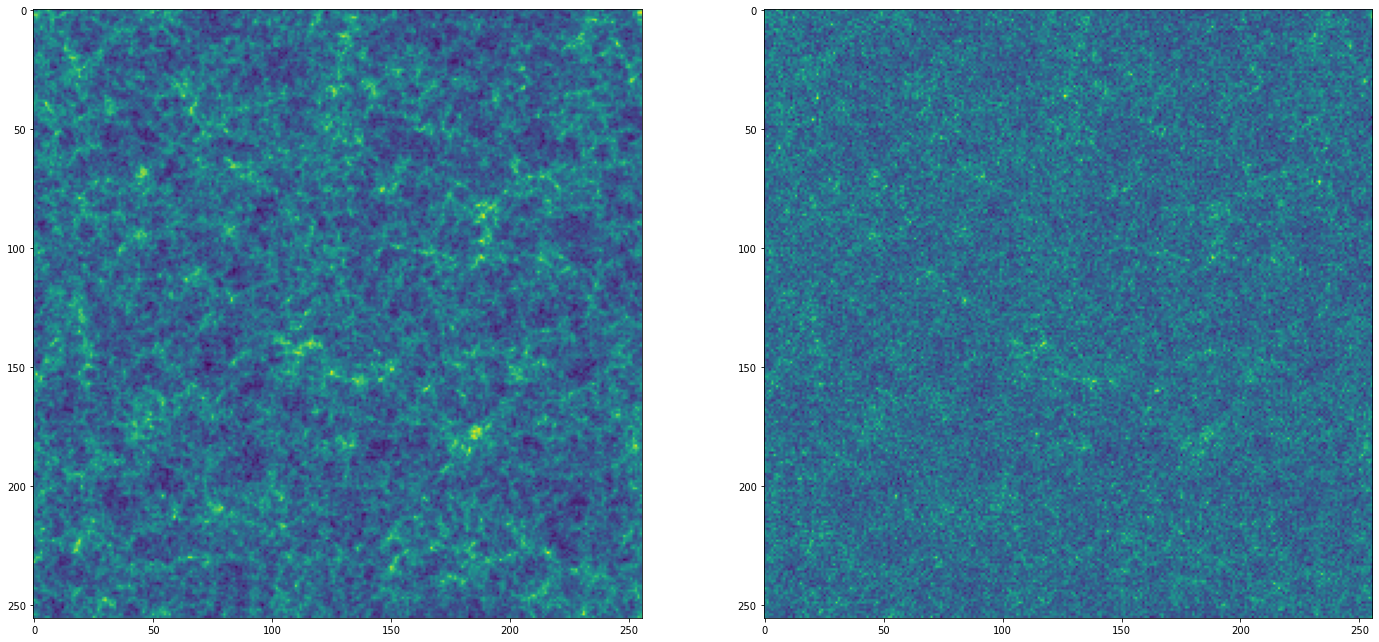

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(delta_dm.paint(mode='real').preview(axes=[1,2]))
ax[1].imshow(delta_g.paint(mode='real').preview(axes=[1,2]))

In [21]:
r = FFTPower(delta_g, mode='1d')
Pkg = r.power['power'].real - r.attrs['shotnoise']
r = FFTPower(delta_g1, mode='1d')
Pkg1 = r.power['power'].real - r.attrs['shotnoise']

Text(0, 0.5, '$P(k) \\, [\\mathrm{h}^3 \\mathrm{Mpc}^{-3}]$')

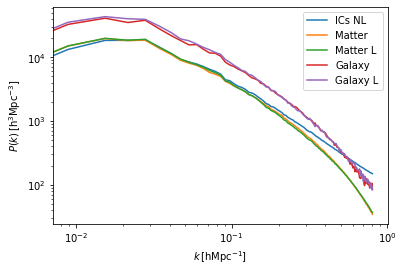

In [22]:
plt.loglog(k, Pknlin, label='ICs NL')
plt.loglog(k, Pkdm, label='Matter')
plt.loglog(k, Pkdm1, label='Matter L')
plt.loglog(k, Pkg, label='Galaxy')
plt.loglog(k, Pkg1, label='Galaxy L')
plt.legend()
plt.xlabel(r'$k \, [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{h}^3 \mathrm{Mpc}^{-3}]$')

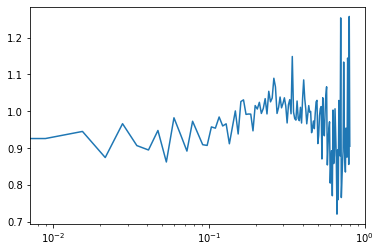

In [23]:
plt.plot(k, Pkg/Pkg1)
plt.xscale('log')

In [24]:
mask = (k>0.03)*(k<=0.09)
bg = np.mean(np.sqrt(Pkg[mask]/Pkdm[mask]))
print('Galaxy bias = {:.2f}'.format(bg))

Galaxy bias = 1.43


Text(0, 0.5, '$\\sqrt{P_g(k)/P_m(k)}$')

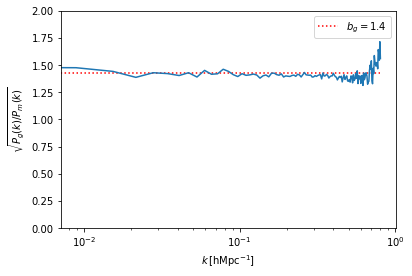

In [25]:
plt.plot(k, np.sqrt(Pkg/Pkdm))
plt.hlines(bg, k.min(), k.max(), linestyles=':', color='r', label=r'$b_g = {:.2}$'.format(bg))
plt.legend()
plt.xscale('log')
plt.ylim(0,2)
plt.xlabel(r'$k \, [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$\sqrt{P_g(k)/P_m(k)}$')

In [26]:
peculiar_field = compute_Psi(Length, Nc, (delta_dm.paint(mode='real') - 1.))

In [27]:
observer = np.array([Length/2,Length/2,Length/2])
vr = compute_vr(field_interpolation(Length, Nc, peculiar_field, galaxy_pos), galaxy_pos, observer, zobs)
# galaxy_posRSD = periodic_conditions(galaxy_pos + vr, Length)
galaxy_cat['PositionRSD'] = galaxy_pos +vr


In [28]:
delta_gRSD = galaxy_cat.to_mesh(position='PositionRSD', resampler='cic', compensated=True, interlaced=True)
r = FFTPower(delta_gRSD, mode='1d')
PkgRSD = r.power['power'].real - r.attrs['shotnoise']

Text(0, 0.5, '$P(k) \\, [\\mathrm{h}^3 \\mathrm{Mpc}^{-3}]$')

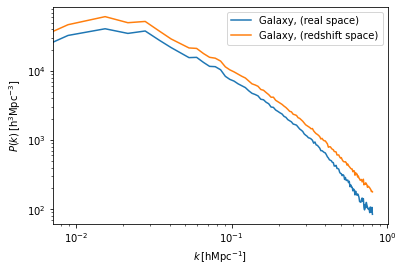

In [29]:
plt.loglog(k, Pkg, label='Galaxy, (real space)')
plt.loglog(k, PkgRSD, label='Galaxy, (redshift space)')
plt.legend()
plt.xlabel(r'$k \, [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{h}^3 \mathrm{Mpc}^{-3}]$')

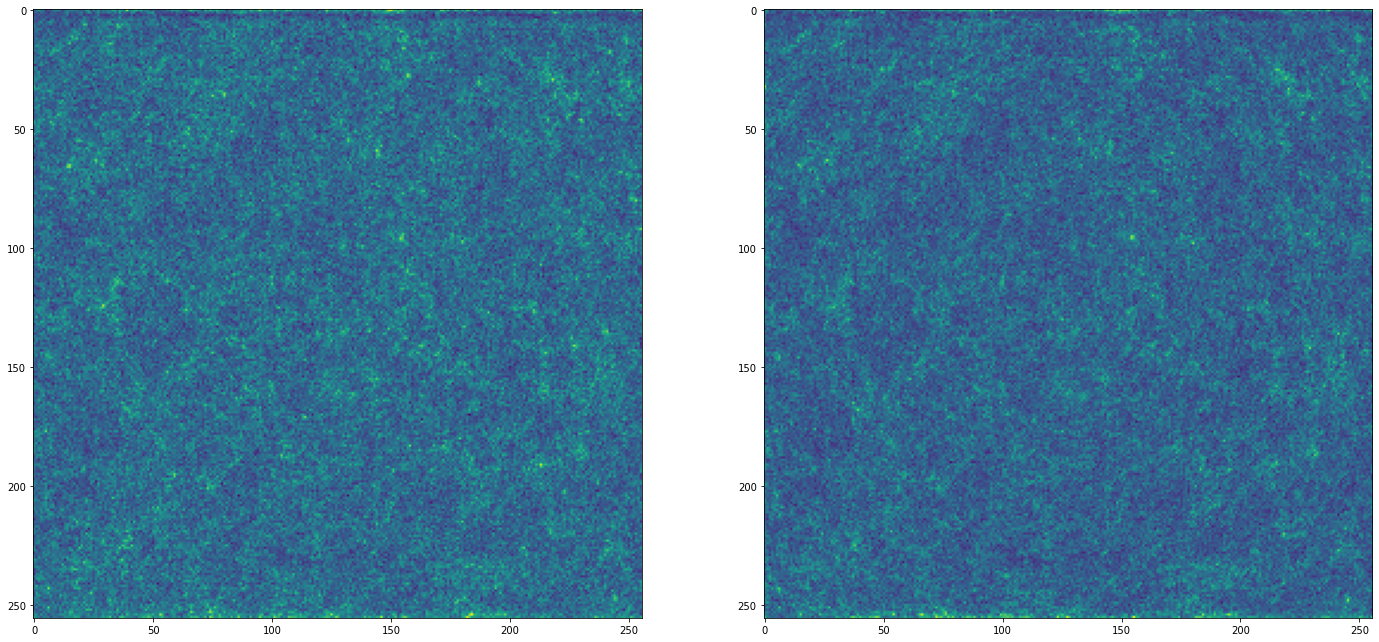

In [30]:
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(delta_g.paint(mode='real').preview(axes=[0,1]))
ax[1].imshow(delta_gRSD.paint(mode='real').preview(axes=[0,1]))

In [29]:
matter_cat.save('Matter_catalog.bigfile')
galaxy_cat.save('Galaxy_catalog.bigfile')